In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing
import warnings
warnings.filterwarnings("ignore")

In [147]:
colspecs = [(2, 10), (10, 22), (56, 69), (82, 95)]
names = ['Data', 'Codigo', 'Preco_Abertura', 'Preco_Fechamento']

df_2022 = pd.read_fwf('COTAHIST_A2022.TXT', colspecs=colspecs, names=names, header=None)
df_2023 = pd.read_fwf('COTAHIST_A2023.TXT', colspecs=colspecs, names=names, header=None)
df_2024 = pd.read_fwf('COTAHIST_A2024.TXT', colspecs=colspecs, names=names, header=None)

frames = [df_2022, df_2023]
df_2022a2023 = pd.concat(frames)


In [148]:
# Filtragem para conter somente 22 e 23
AMAZON_df = df_2022a2023[df_2022a2023['Codigo'].str.endswith('AMZO34')].copy()
AMAZON_df['Data'] = pd.to_datetime(AMAZON_df['Data'], format='%Y%m%d')
AMAZON_df['Ano'] = AMAZON_df['Data'].dt.year
AMAZON_df['Mes'] = AMAZON_df['Data'].dt.month
AMAZON_df['Dia'] = AMAZON_df['Data'].dt.day
AMAZON_df.set_index('Data', inplace=True)
AMAZON_df.sort_index(inplace=True)

In [149]:
AMAZON_df_2024 = df_2024[df_2024['Codigo'].str.endswith('AMZO34')].copy()
AMAZON_df_2024['Data'] = pd.to_datetime(AMAZON_df_2024['Data'], format='%Y%m%d')
AMAZON_df_2024['Ano'] = AMAZON_df_2024['Data'].dt.year
AMAZON_df_2024['Mes'] = AMAZON_df_2024['Data'].dt.month
AMAZON_df_2024['Dia'] = AMAZON_df_2024['Data'].dt.day
AMAZON_df_2024.set_index('Data', inplace=True)
AMAZON_df_2024.sort_index(inplace=True)

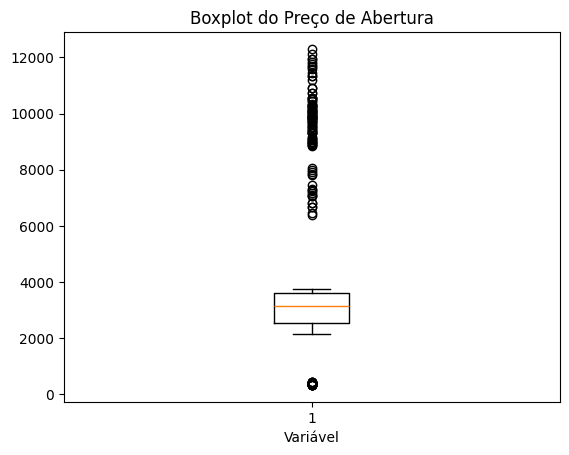

In [150]:
plt.boxplot(AMAZON_df['Preco_Abertura'])
plt.title('Boxplot do Preço de Abertura')
plt.xlabel('Variável')
plt.show()


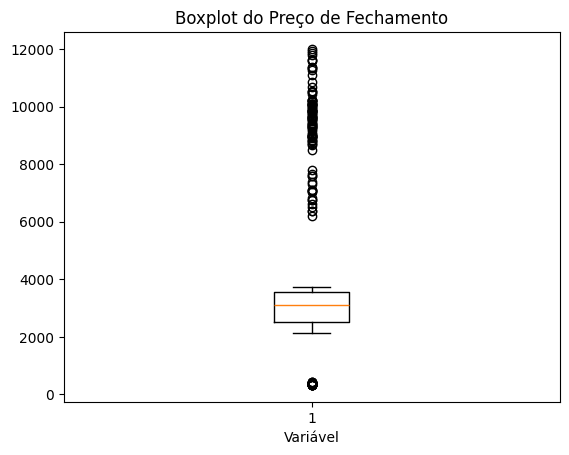

In [151]:
plt.boxplot(AMAZON_df['Preco_Fechamento'])
plt.title('Boxplot do Preço de Fechamento')
plt.xlabel('Variável')
plt.show()

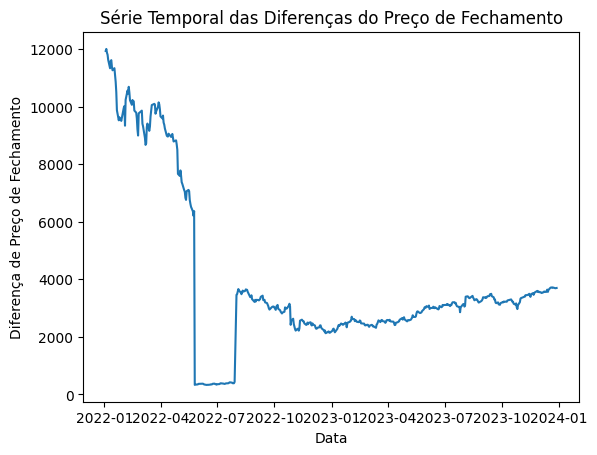

In [152]:
result = seasonal_decompose(AMAZON_df['Preco_Fechamento'], model='additive', period=30)

# Visualização da série temporal das diferenças do preço de fechamento
AMAZON_df['Diferenca'] = AMAZON_df['Preco_Fechamento']
plt.plot(AMAZON_df['Diferenca'])
plt.title('Série Temporal das Diferenças do Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Diferença de Preço de Fechamento')
plt.show()

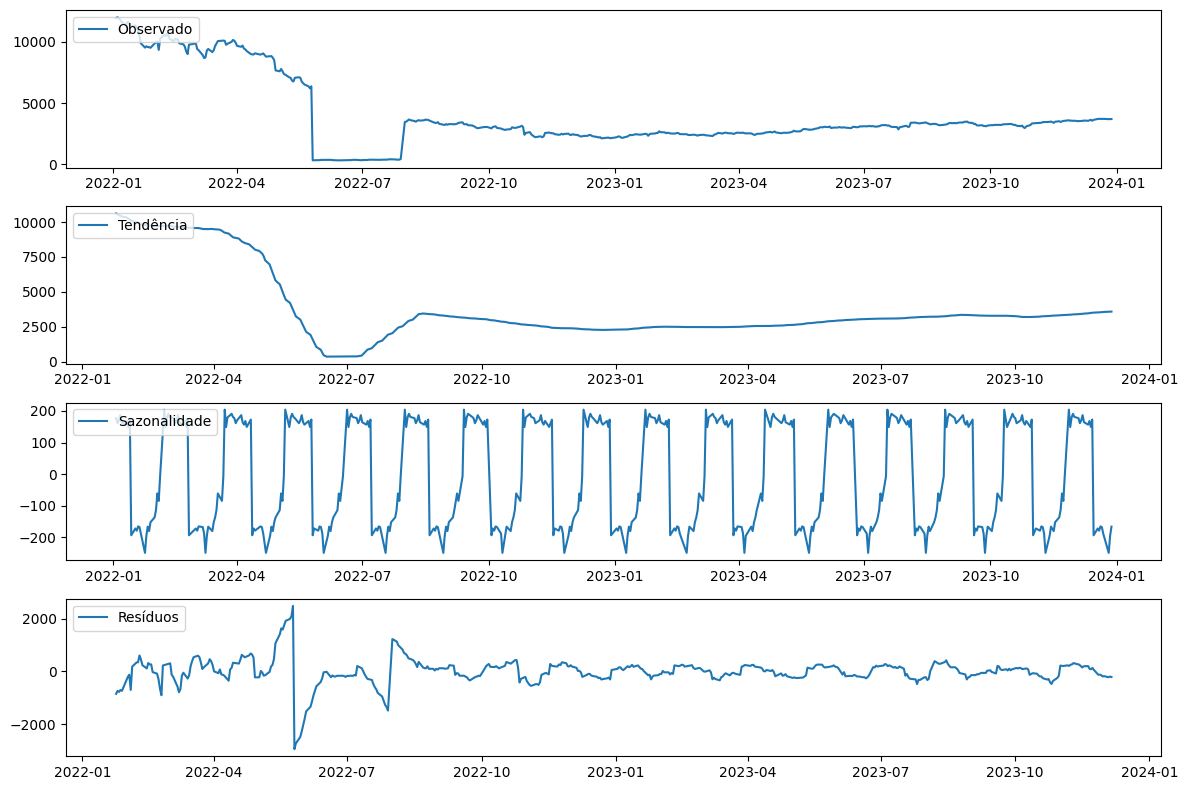

In [190]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Tendência')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Sazonalidade')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Resíduos')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [197]:
# Suavização exponencial
alpha = 0.2  # Fator de suavização
model_exp = SimpleExpSmoothing(AMAZON_df['Preco_Fechamento']).fit(smoothing_level=alpha)
AMAZON_df['Suavizacao_EXP'] = model_exp.fittedvalues

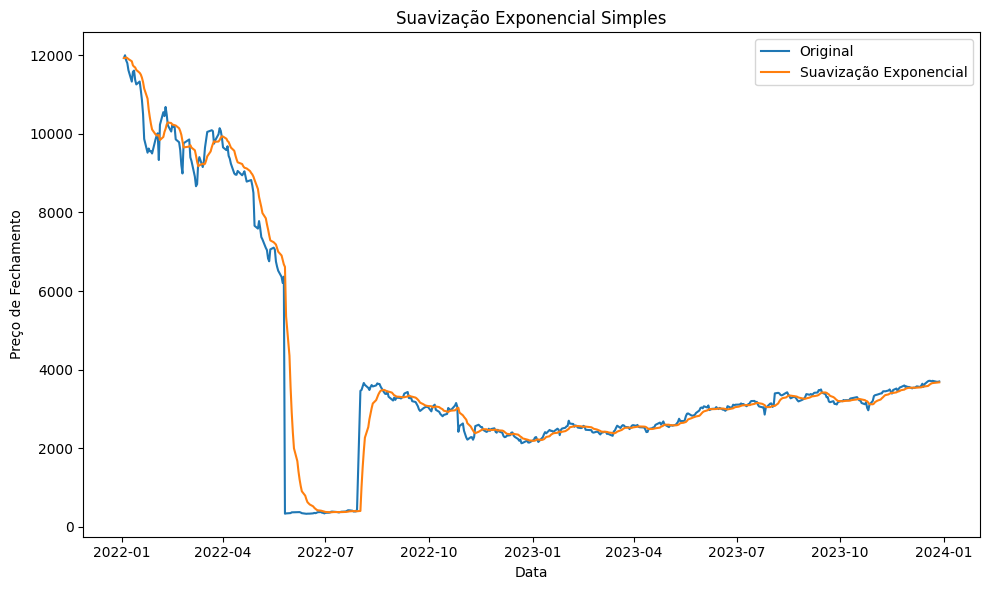

In [198]:
# Plotando a suavização exponencial
plt.figure(figsize=(10, 6))
plt.plot(AMAZON_df.index, AMAZON_df['Preco_Fechamento'], label='Original')
plt.plot(AMAZON_df.index, AMAZON_df['Suavizacao_EXP'], label='Suavização Exponencial')
plt.title('Suavização Exponencial Simples')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.tight_layout()
plt.show()

In [199]:

# Ajuste do modelo ARIMA nos dados suavizados
resultado_teste = adfuller(AMAZON_df['Suavizacao_EXP'].dropna())
print('Estatística do teste:', resultado_teste[0])
print('Valor-p:', resultado_teste[1])

Estatística do teste: -2.7843912194182363
Valor-p: 0.0605381940051903


In [157]:
# # Treinar modelo ARIMA
# modelo_arima = auto_arima(AMAZON_df['Suavizacao_EXP'], seasonal=False, suppress_warnings=True)

# # Horizonte de previsão
# horizonte = 10

# # Fazer previsões para 2024 usando os dados de teste (AMAZON_df_2024)
# previsoes_finais = modelo_arima.predict(n_periods=horizonte)

# print(previsoes_finais)

In [200]:
# Treinamento do modelo ARIMA
model = auto_arima(AMAZON_df['Suavizacao_EXP'], seasonal=True, trace=True)  # auto_arima selecionará os melhores parâmetros
horizonte = 10
model.fit(AMAZON_df['Suavizacao_EXP'])

# Previsão para os dados de teste
previsoes_finais = model.predict(n_periods=horizonte)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5609.789, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=5605.854, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=5604.326, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=5599.711, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=5597.927, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=5594.827, Time=0.11 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,2,5)(0,0,0)[0]             : AIC=5590.224, Time=0.17 sec
 ARIMA(1,2,5)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=5592.216, Time=0.33 sec

Best model:  ARIMA(0,2,5)(0,0,0)[0]          
Total fit time: 

In [201]:
previsoes_df = pd.DataFrame(previsoes_finais, columns=['Previsao'])

# Convertendo o índice para o formato de data
previsoes_df.index = pd.date_range(start=AMAZON_df.index[-1] + pd.Timedelta(days=1), periods=len(previsoes_df), freq='D')

# Convertendo para uma representação em string
texto_previsoes = previsoes_df.to_string()

print(texto_previsoes)


               Previsao
2023-12-29  3682.463832
2023-12-30  3689.371992
2023-12-31  3696.964120
2024-01-01  3705.524155
2024-01-02  3714.276727
2024-01-03  3723.029300
2024-01-04  3731.781872
2024-01-05  3740.534445
2024-01-06  3749.287018
2024-01-07  3758.039590


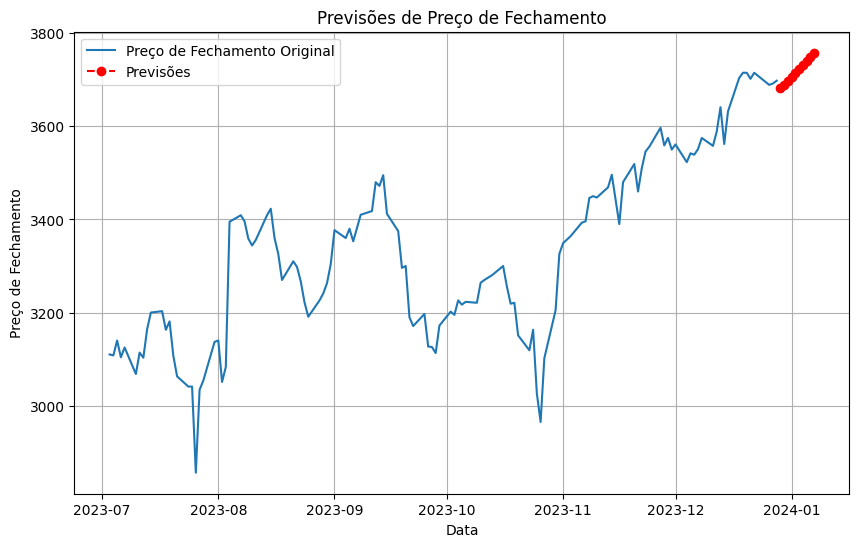

In [202]:
data_inicio = '2023-07-01'

# Selecionando os dados a partir da data de início
AMAZON_df_plot = AMAZON_df[data_inicio:]
previsoes_df_plot = previsoes_df[data_inicio:]

# Plot das previsões
plt.figure(figsize=(10, 6))
plt.plot(AMAZON_df_plot.index, AMAZON_df_plot['Preco_Fechamento'], label='Preço de Fechamento Original')
plt.plot(previsoes_df_plot.index, previsoes_df_plot['Previsao'], marker='o', linestyle='--', color='red', label='Previsões')
plt.title('Previsões de Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

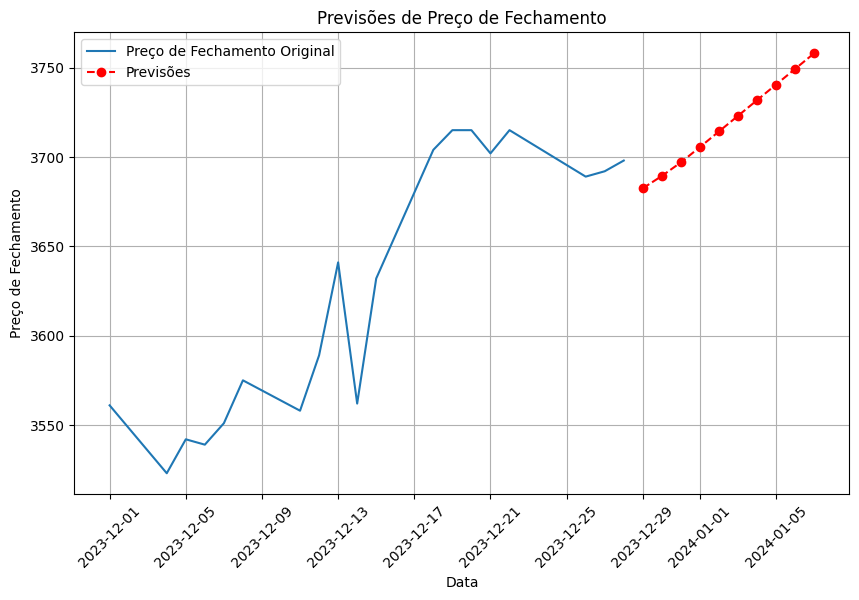

In [203]:
# Definindo a data de início
data_inicio = '2023-12-01'

# Selecionando os dados a partir da data de início
AMAZON_df_plot = AMAZON_df[data_inicio:]
previsoes_df_plot = previsoes_df[data_inicio:]

# Plot das previsões
plt.figure(figsize=(10, 6))
plt.plot(AMAZON_df_plot.index, AMAZON_df_plot['Preco_Fechamento'], label='Preço de Fechamento Original')
plt.plot(previsoes_df_plot.index, previsoes_df_plot['Previsao'], marker='o', linestyle='--', color='red', label='Previsões')
plt.title('Previsões de Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotação de 45 graus no eixo x
plt.legend()
plt.grid(True)

plt.show()